In [1]:
import sagemaker
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'sagemaker/DEMO-xgboost-diabetes'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

In [3]:
dataset = pd.read_csv('./diabetes.csv')
pd.set_option('display.max_columns', 500)
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


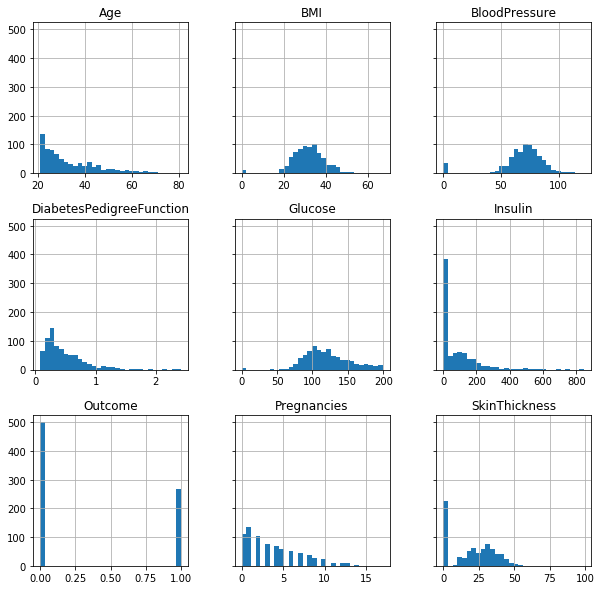

In [4]:
for column in dataset.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=dataset[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(dataset.describe())
%matplotlib inline
hist = dataset.hist(bins=30, sharey=True, figsize=(10, 10))

In [5]:
diabetes_map = {1:1, 0:2}
dataset['Outcome'] = dataset['Outcome'].map(diabetes_map)
# mark zero values as missing or NaN
dataset = dataset.replace(0, np.NaN)
# fill missing values with mean column values
dataset.fillna(dataset.mean(), inplace=True)
diabetes_map = {1:1, 2:0}
dataset['Outcome'] = dataset['Outcome'].map(diabetes_map)
# count the number of NaN values in each column
print(dataset.isnull().sum())
dataset

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000000,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1.000000,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8.000000,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1.000000,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,4.494673,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10.000000,101.0,76.0,48.00000,180.000000,32.9,0.171,63,0
764,2.000000,122.0,70.0,27.00000,155.548223,36.8,0.340,27,0
765,5.000000,121.0,72.0,23.00000,112.000000,26.2,0.245,30,0
766,1.000000,126.0,60.0,29.15342,155.548223,30.1,0.349,47,1


In [6]:

model_data = pd.get_dummies(dataset)
model_data = pd.concat([model_data['Outcome'], model_data.drop(['Outcome'], axis=1)], axis=1)
model_data

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6.000000,148.0,72.0,35.00000,155.548223,33.6,0.627,50
1,0,1.000000,85.0,66.0,29.00000,155.548223,26.6,0.351,31
2,1,8.000000,183.0,64.0,29.15342,155.548223,23.3,0.672,32
3,0,1.000000,89.0,66.0,23.00000,94.000000,28.1,0.167,21
4,1,4.494673,137.0,40.0,35.00000,168.000000,43.1,2.288,33
...,...,...,...,...,...,...,...,...,...
763,0,10.000000,101.0,76.0,48.00000,180.000000,32.9,0.171,63
764,0,2.000000,122.0,70.0,27.00000,155.548223,36.8,0.340,27
765,0,5.000000,121.0,72.0,23.00000,112.000000,26.2,0.245,30
766,1,1.000000,126.0,60.0,29.15342,155.548223,30.1,0.349,47


In [7]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [8]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [9]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [10]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [11]:

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.large',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=5,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-06 07:52:37 Starting - Starting the training job...
2020-10-06 07:52:39 Starting - Launching requested ML instances......
2020-10-06 07:53:44 Starting - Preparing the instances for training...
2020-10-06 07:54:27 Downloading - Downloading input data...
2020-10-06 07:54:58 Training - Downloading the training image..Arguments: train
[2020-10-06:07:55:14:INFO] Running standalone xgboost training.
[2020-10-06:07:55:14:INFO] File size need to be processed in the node: 0.04mb. Available memory size in the node: 194.61mb
[2020-10-06:07:55:14:INFO] Determined delimiter of CSV input is ','
[07:55:14] S3DistributionType set as FullyReplicated
[07:55:14] 537x8 matrix with 4296 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-10-06:07:55:14:INFO] Determined delimiter of CSV input is ','
[07:55:14] S3DistributionType set as FullyReplicated
[07:55:14] 154x8 matrix with 1232 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&del

In [12]:
compiled_model = xgb
if xgb.create_model().check_neo_region(boto3.Session().region_name) is False:
    print('Neo is not currently supported in', boto3.Session().region_name)
else:
    output_path = '/'.join(xgb.output_path.split('/')[:-1])
    compiled_model = xgb.compile_model(target_instance_family='ml_m5', 
                                       input_shape={'data': [1, 69]},
                                       role=role,
                                       framework='xgboost',
                                       framework_version='0.7',
                                       output_path=output_path)
    compiled_model.name = 'deployed-xgboost-diabetes'
    compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


?..!

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [13]:
xgb_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')

Using already existing model: deployed-xgboost-diabetesml-m5


---------------!

In [14]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [15]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:,1:])

In [16]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,39,8
1,13,17


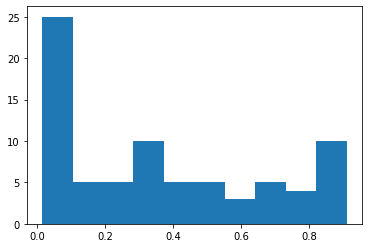

In [17]:
plt.hist(predictions)
plt.show()

In [18]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Outcome,,
0,29,18
1,9,21


In [19]:
cm = pd.crosstab(index=test_data['Outcome'], columns=np.round(predictions), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No", "Yes"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Yes", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 72.7%

Predicted      No                  Yes
Observed
No             75% (39)    32% (8)
Yes             25% (13)     68% (17) 



In [20]:
linear_endpoint = 'DEMO-linear-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())
print(linear_endpoint)

DEMO-linear-endpoint-202010060803
